# Table of Contents   

Machine Learning <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a. [Preprocessing](#preprocess)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b. [Ridge Model with CountVectorizer](#count)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c. [Ridge Model with TfidVectorizer](#tfid)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d. [Random Forest](#forest)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e. [XG Boosting](#boost)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; f. [Deep Learning](#learn)<br>

In [1]:
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Activation, Concatenate
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras import Model
from keras.optimizers import Adam
import shap

Using TensorFlow backend.
C:\Users\sadmin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sadmin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sadmin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sadmin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

## 3. Machine Learning

### a. Preprocessing
<a id='preprocess'></a>

In [2]:
#load processed data
df = pd.read_csv('../Data/Processed/After_EDA_listings.csv', converters = {
    'name': literal_eval, 'description': literal_eval, 
    'bigram_name': literal_eval, 'bigram_description': literal_eval})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33466 entries, 0 to 33465
Data columns (total 37 columns):
Unnamed: 0                     33466 non-null int64
Unnamed: 0.1                   33466 non-null int64
name                           33466 non-null object
description                    33466 non-null object
transit                        33466 non-null bool
host_response_time             33466 non-null object
host_response_rate             33466 non-null float64
host_is_superhost              33466 non-null object
host_has_profile_pic           33466 non-null object
host_identity_verified         33466 non-null object
neighbourhood                  33466 non-null object
property_type                  33466 non-null object
room_type                      33466 non-null object
accommodates                   33466 non-null int64
bathrooms                      33466 non-null float64
bedrooms                       33466 non-null float64
beds                           33466 non-null

In [4]:
#show what amenities look like
df.amenities[0]

'{TV,"Cable TV",Internet,Wifi,"Air conditioning","Wheelchair accessible",Pool,Kitchen,"Free parking on premises","Pets allowed",Gym,Elevator,"Hot tub","Indoor fireplace","Buzzer/wireless intercom",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}'

In [5]:
df.amenities = df.amenities.replace(to_replace = '["\d\s\-\/{\}]', value='', regex=True)

#find all the items in the amenities and put it in a dummy dictionary
amenities = {}
def find_list(string):
    first = 0
    for index, character in enumerate(string):
        if character == ",":
            if string[first:index] not in amenities:
                amenities[string[first:index]] = []
            first = index+1
    if string[first:] not in amenities:
            amenities[string[first:]] = []
df.amenities.apply(lambda x: find_list(x))

0        None
1        None
2        None
3        None
4        None
         ... 
33461    None
33462    None
33463    None
33464    None
33465    None
Name: amenities, Length: 33466, dtype: object

In [6]:
count = 0

#find the amenities for each row and add 1 to the dictionary list if the item is there
#and 0 if item is not there
def labeling(string):
    global amenities
    first = 0
    for index, character in enumerate(string):
        if character == ",":
            if string[first:index] in amenities:
                amenities[string[first:index]].append(1)
    global count
    count+=1
    for key, value in amenities.items():
        if len(value) < count:
            amenities[key].append(0)

df.amenities.apply(lambda x: labeling(x))

0        None
1        None
2        None
3        None
4        None
         ... 
33461    None
33462    None
33463    None
33464    None
33465    None
Name: amenities, Length: 33466, dtype: object

In [7]:
#create dataframe from amenities dictionary
df2 = pd.DataFrame(amenities)

#reset index
df = df.reset_index()

#concatenate dataframe
df = pd.concat([df, df2], axis=1, sort=False)

#get all keys in list form
keys = list(amenities.keys())

In [8]:
#combined the previously tokenized title and summary for sklearn bag of words and Tfidf
#text has already been preprocessed previously by removing non-english campaign, lowercase, stopwords, stemming/lemmatizing
df['name'] = df['name'].apply(lambda x: ' '.join(x))
df['description'] = df['description'].apply(lambda x: ' '.join(x))

#merge the title and summary to one text
df['name_description'] = df['name'] + ' ' + df['description']

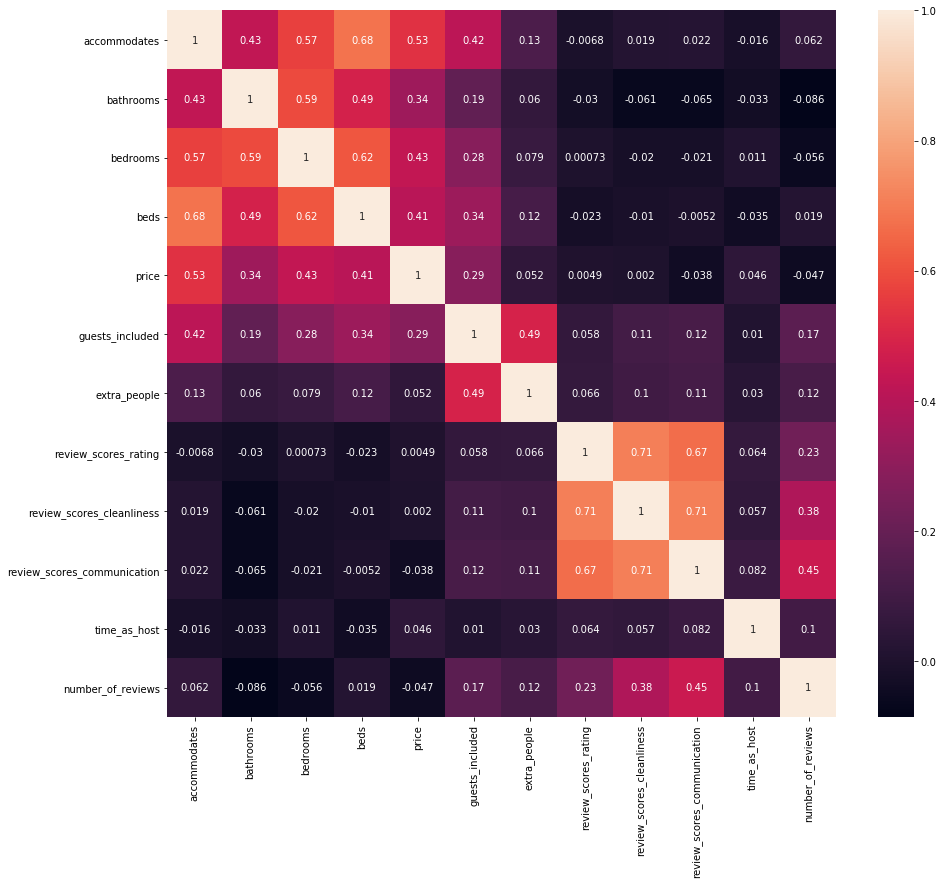

In [9]:
get_numeric = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 
               'guests_included', 'extra_people', 'review_scores_rating', 
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'number_of_reviews']

corr = df[get_numeric].corr(method = 'kendall')

plt.figure(figsize = (15,13))
sns.heatmap(corr, annot = True)

The correlation heatmap shows some strong collinearity between features. We can transform the features using PCA to remove collinearity while preserving the effect on the target variable or we can drop features. In this case, because of the computational expense and limited memory, we will just remove features. However, after testing our model, it appears that dropping features ended up costing the performance of all the models and as a result, the features were maintained and not removed

In [10]:
#select features
X = df[['name_description', 'transit', 'host_has_profile_pic',
              'host_identity_verified', 'neighbourhood', 'property_type',
              'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
              'bed_type', 'price', 'security_deposit', 'cleaning_fee',
              'guests_included', 'extra_people', 'review_scores_rating', 
              'review_scores_cleanliness', 'review_scores_communication', 
              'instant_bookable', 'time_as_host', 'weekly_price', 
              'host_is_superhost', 'host_response_rate', 'host_response_time'] + keys]

#select target
y = df[['number_of_reviews']]

#split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print('Number of features: {}'.format(len(df.columns)))

Number of features: 262


In [11]:
#numeric features
get_numeric = ['accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people', 'review_scores_rating', 
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate']

#categorical features
get_categorical = ['transit', 'host_has_profile_pic', 'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys

#text feature
get_text = 'name_description'

#numeric pipeline
num_pipe = Pipeline([('scale', StandardScaler())])

#categorical pipeline1
#first encode category columns using onehot encoding
cat_pipe = Pipeline([('onehot', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
                     #remove features with low variance set at 97% of the population
                     ('varthres', VarianceThreshold(threshold = 0.97*(1-0.97)))])




#text pipeline for CountVectorizer
#countvectorization with maximum features of 10000 to reduce overfitting the model 
#and remove any vocabulary/phrases with less 20 counts 
text_pipe1 = Pipeline([('Count', CountVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])

#text pipeline for Tfidf
#TfidfVectorization with maximum features of 10000 to reduce overfitting the model 
#and remove any vocabulary/phrases with less 20 counts 
text_pipe2 = Pipeline([('Tfid', TfidfVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])

#preprocesscor for Bag of words
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', num_pipe, get_numeric),
        ('cat', cat_pipe, get_categorical),
        ('text1', text_pipe1, get_text)])

#preprocessor for Tf-idf
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_pipe, get_numeric),
        ('cat', cat_pipe, get_categorical),
        ('text2', text_pipe2, get_text)])

### b. Ridge with CountVectorizer
<a id='count'></a>

In [12]:
#create Bag of words pipeline with logistic regression
pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Ridge())])

#Randomized cross validation with fine tuning alpha
param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf1 = RandomizedSearchCV(pipe1, param_grid, cv = 3, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 12)

clf1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.5min
[Parallel(

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [13]:
#model the test set
print(clf1.best_params_)

{'regressor__alpha': 568.9866029018293}


In [14]:
#model the test set
y_pred = clf1.predict(X_test)

train_r2 = round(clf1.score(X_train, y_train), 2)
test_r2 = round(r2_score(y_test, y_pred), 2)

print("Training set r2:", train_r2)
print("Testing set r2:", test_r2)

Training set r2: 0.41
Testing set r2: 0.32


In [15]:
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Mean square error: 2541.68
Max error: 777.17
Mean absolute error: 31.42


In [16]:
y_pred[:10]

array([[ 70.40107429],
       [ 19.63992243],
       [ 11.86245884],
       [ 54.48486863],
       [ -3.17349722],
       [111.94884716],
       [ 94.83829028],
       [ 98.47895474],
       [ 41.57601679],
       [ 19.69729657]])

We have values less than zero, which does not make sense. We can modified the y_pred to better match reality by setting it to zero

In [17]:
#set everything less than 0 to 0
def zero_baseline(prediction):
    for ind, predict in enumerate(prediction):
        if predict<0:
            prediction[ind] = 0
    return prediction
y_pred = zero_baseline(y_pred)

In [18]:
y_pred[:10]

array([[ 70.40107429],
       [ 19.63992243],
       [ 11.86245884],
       [ 54.48486863],
       [  0.        ],
       [111.94884716],
       [ 94.83829028],
       [ 98.47895474],
       [ 41.57601679],
       [ 19.69729657]])

All the negative reviews have become zero

In [19]:
y_pred = zero_baseline(y_pred)

test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2 after setting baseline:", test_r2)

mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error after setting baseline:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error after setting baseline:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error after setting baseline:', mae)

Testing set r2 after setting baseline: 0.33
Mean square error after setting baseline: 2494.71
Max error after setting baseline: 777.17
Mean absolute error after setting baseline: 29.53


All metrics have a moderate improvement

### c. Ridge with TfidVectorizer
<a id='tfid'></a>

In [20]:
pipe2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Ridge())])

clf2 = RandomizedSearchCV(pipe2, param_grid, cv = 3, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 12, verbose = 15)
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   40.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   56.6s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  1.2min
[Parallel(

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [21]:
print(clf2.best_params_)

{'regressor__alpha': 5.17947467923121}


In [22]:
#model the test set
y_pred = clf2.predict(X_test)

train_r2 = round(clf2.score(X_train, y_train), 2)
test_r2 = round(r2_score(y_test, y_pred), 2)

print("Training set r2:", train_r2)
print("Testing set r2:", test_r2)

Training set r2: 0.43
Testing set r2: 0.32


In [23]:
y_pred = zero_baseline(y_pred)

test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2 after setting baseline:", test_r2)

mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error after setting baseline:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error after setting baseline:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error after setting baseline:', mae)

Testing set r2 after setting baseline: 0.34
Mean square error after setting baseline: 2479.73
Max error after setting baseline: 779.7
Mean absolute error after setting baseline: 29.39


### d. Random Forest
<a id='forest'></a>

In [24]:
#create pipeline for random forest algorithm
pipe3 = Pipeline([('preprocessor', preprocessor1),
                  ('regressor', RandomForestRegressor())])

param_grid = {'regressor__n_estimators': np.arange(8,17,2), 
              'regressor__min_samples_split': np.arange(2,6),
             'regressor__min_samples_leaf': np.arange(1,5)}

clf3 = RandomizedSearchCV(pipe3, param_grid, cv = 3, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 12, verbose = 15)
clf3.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed: 15.5min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed: 19.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed: 24.4min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed: 28.6min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 31.6min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 32.1min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed: 37.4min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 37.4min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed: 40.2min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed: 40.9min
[Parallel(

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [25]:
print(clf3.best_params_)

{'regressor__n_estimators': 16, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 4}


In [26]:
#model the test set
y_pred = clf3.predict(X_test)

train_r2 = round(clf3.score(X_train, y_train), 2)
test_r2 = round(r2_score(y_test, y_pred), 2)

print("Training set r2:", train_r2)
print("Testing set r2:", test_r2)

Training set r2: 0.77
Testing set r2: 0.41


In [27]:
y_pred = zero_baseline(y_pred)

test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2 after setting baseline:", test_r2)

mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error after setting baseline:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error after setting baseline:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error after setting baseline:', mae)

Testing set r2 after setting baseline: 0.41
Mean square error after setting baseline: 2193.45
Max error after setting baseline: 784.85
Mean absolute error after setting baseline: 23.5


In [28]:
#get feature importance
importance = clf3.best_estimator_['regressor'].feature_importances_
print('Number of feature importance: {}'.format(len(importance)))

Number of feature importance: 9140


In [29]:
#because of pipeline processing, we need to get the updated categorical labels

#We get teh label names after onehotencoder
label_for_ohe = clf3.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()

#we get booleans of the features used after VarianceThreshold
boolean_feature_used = clf3.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

#list of used categorical features
cat_label_used = []

#a function to identify which labels were used in categorical features
for ind, boolean in enumerate(boolean_feature_used):
    if boolean:
        cat_label_used.append(label_for_ohe[ind])

In [30]:
#find the vocabulary used after bag of words
vocabulary_used = list(clf3.best_estimator_['preprocessor'].named_transformers_['text1']['Count'].vocabulary_.keys())

In [31]:
#combine labels and print number of labels for validation
labels = get_numeric+cat_label_used + vocabulary_used
print('Number of labels: {}'.format(len(labels)))

Number of labels: 9140


In [32]:
#sort the labels by importance
sorted_importance = sorted(list(zip(labels, importance)), key = lambda x: x[1], reverse = True)

#get the sorted labels and feature importance
sort_label = []
sort_importance = []
for label, value in sorted_importance:
    sort_label.append(label)
    sort_importance.append(value)

Text(0, 0.5, 'Feature Importances')

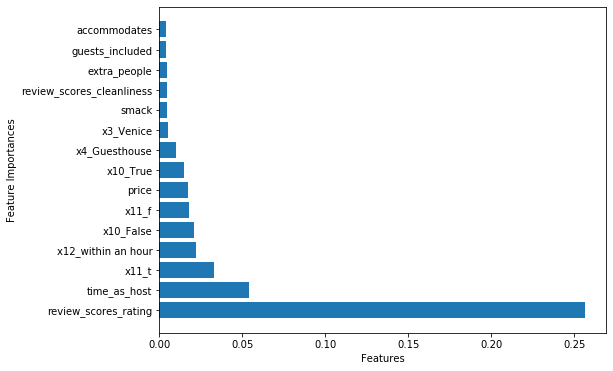

In [33]:
plt.figure(figsize = (8,6))
plt.barh(sort_label[:15], sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')

Review scores rating overwelmingly contributes to the overall prediction of number of reviews compared other features.

### e. XG Boosting
<a id='boost'></a>

In [34]:
#create pipeline for gradient boosted random forest algorithm
pipe4 = Pipeline([('preprocessor', preprocessor1), 
                  ('regressor', XGBRegressor())])

param_grid = {'regressor__n_estimators': [100, 200, 300, 400, 500],
              'regressor__learning_rate': [0.001, 0.01, 0.1, 0.3],
              'regressor__max_depth': np.arange(3,6), 
              'regressor__reg_alpha': np.arange(0,1,0.1)}

clf4 = RandomizedSearchCV(pipe4, param_grid, cv = 3, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 12, verbose = 15)
clf4.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed: 14.2min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed: 14.9min
[Parallel(

[12:37:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [35]:
print(clf4.best_params_)

{'regressor__reg_alpha': 0.30000000000000004, 'regressor__n_estimators': 400, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1}


In [36]:
#model the test set
y_pred = clf4.predict(X_test)

train_r2 = round(clf4.score(X_train, y_train), 2)
test_r2 = round(r2_score(y_test, y_pred), 2)

print("Training set r2:", train_r2)
print("Testing set r2:", test_r2)

Training set r2: 0.63
Testing set r2: 0.42


In [37]:
y_pred = zero_baseline(y_pred)

test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2 after setting baseline:", test_r2)

mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error after setting baseline:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error after setting baseline:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error after setting baseline:', mae)

Testing set r2 after setting baseline: 0.42
Mean square error after setting baseline: 2163.8
Max error after setting baseline: 759.86
Mean absolute error after setting baseline: 25.41


Text(0, 0.5, 'Feature Importances')

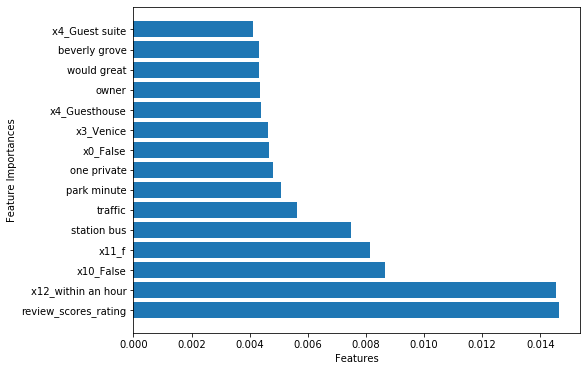

In [38]:
xgImportance = clf4.best_estimator_['regressor'].feature_importances_


#sort the labels by importance
sorted_xgImportance = sorted(list(zip(labels, xgImportance)), key = lambda x: x[1], reverse = True)

#get the sorted labels and feature importance
sort_xglabel = []
sort_xgimportance = []
for label, value in sorted_xgImportance:
    sort_xglabel.append(label)
    sort_xgimportance.append(value)

    
plt.figure(figsize = (8,6))
plt.barh(sort_xglabel[:15], sort_xgimportance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')

In [39]:
#explain model with shap
#because shap only accepts arrays as arguments we must convert the processed X_train to an array
x_process = clf4.best_estimator_['preprocessor'].fit_transform(X_train)
x_array_train = x_process.toarray()

In [40]:
#retrain the classifier with the new array while keeping the best estimator
classifier = clf4.best_estimator_['regressor']
classifier.fit(x_array_train,y_train)

[12:40:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.30000000000000004, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [41]:
#fit the XGB to the TreeExplainer
XGBexplainer = shap.TreeExplainer(classifier, data = x_array_train[:100])

shap_values = XGBexplainer.shap_values(x_array_train[:100])

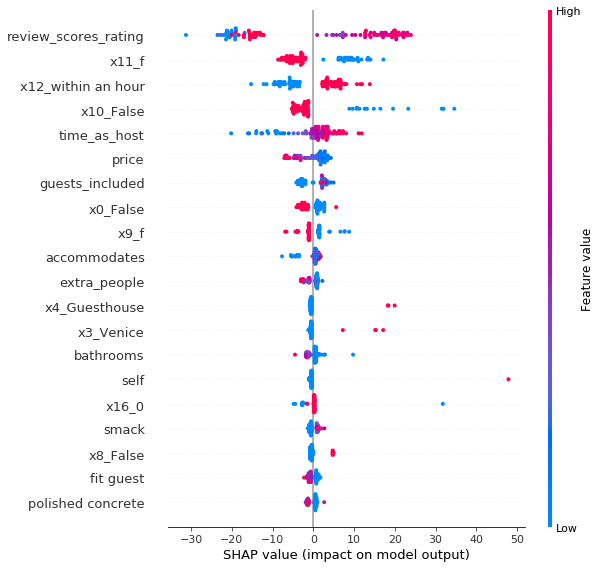

In [42]:
shap.summary_plot(shap_values, x_array_train[:100], feature_names=labels)

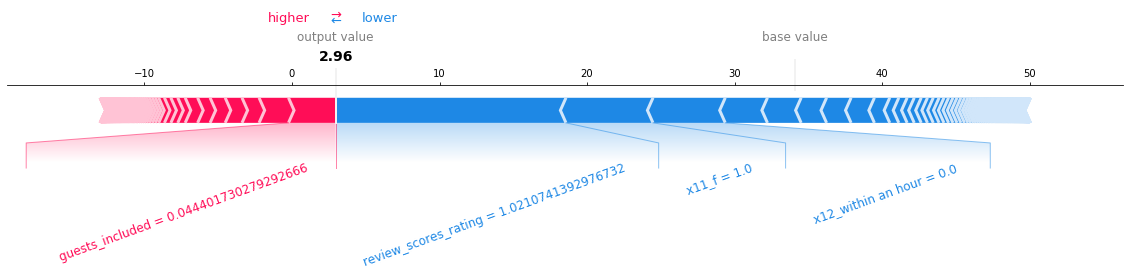

In [43]:
shap.force_plot(XGBexplainer.expected_value, shap_values[0], x_array_train[0], matplotlib=True, 
                feature_names=labels, text_rotation=20)

### f. Deep Learning
<a id='learn'></a>

In [44]:
#text to sequence for title with max # words of 10000
tokenizer_tit = Tokenizer(num_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_tit.fit_on_texts(df['name_description'])
X_name = tokenizer_tit.texts_to_sequences(df['name_description'])

In [45]:
X_name = pad_sequences(X_name, maxlen=50, padding = 'post')

In [46]:
#scale numerical features
scale = StandardScaler()
temp1 = scale.fit_transform(df[get_numeric])

#encode categorical features
onehot = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
temp2 = onehot.fit_transform(df[get_categorical])
varthre = VarianceThreshold(threshold = 0.99*(1-0.99))
temp2 = varthre.fit_transform(temp2)

#concatenate numerical and categorical features
X = np.concatenate((temp1,temp2), axis = 1)

#set target variable
y = df['number_of_reviews']
y = np.array(y).reshape((-1,1))

In [47]:
X_name_train, X_name_test, X_train, X_test, y_train, y_test = (
    train_test_split(X_name, X, y, test_size = 0.2, random_state = 10))

In [48]:
#input shape
seq_length = X_name.shape[1]
meta_length = X.shape[1]

In [49]:
#create nlp input
nlp_input = Input(shape=(seq_length,), name='nlp_input')

#create categorical and numerical input
meta_input = Input(shape=(meta_length,), name='meta_input')

#embedding for title with word vector size of 50 
emb = Embedding(input_dim = 10000, output_dim=100, input_length=seq_length)(nlp_input)
#LSTM network with 64 memory unit
nlp_out = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(emb)


#meta input and layer1
meta_layer1 = Dense(256, input_shape = (meta_length,))(meta_input)
meta_layer1 = Activation('relu')(meta_layer1)

#layer2
meta_layer2 = Dense(128)(meta_layer1)
meta_layer2 = Dropout(0.3)(meta_layer2)
meta_layer2 = Activation('relu')(meta_layer2)

#layer3
meta_layer3 = Dense(64, kernel_regularizer=regularizers.l2(0.02))(meta_layer2)
meta_layer3 = BatchNormalization()(meta_layer3)
meta_out = Activation('relu')(meta_layer3)


#merge layers
merged_X = Concatenate(axis = 1)([nlp_out, meta_out])

#fully connected layers
FC1 = Dense(64, activation='relu')(merged_X)
FC2 = Dense(64, activation='relu')(FC1)
FC3 = Dense(1, activation='linear')(FC2)
model = Model(inputs=[nlp_input, meta_input], outputs=[FC3])

#use binary cross entropy because we have a binary classification with Adam optimizer at learning rate of 0.00003
model.compile(optimizer =  Adam(lr=0.00004), loss = 'mean_squared_error', metrics = ['mae'])
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]
                         
hist = model.fit([X_name_train, X_train], y_train, 
               validation_split = 0.2, batch_size = 128, epochs = 500, verbose = 2, callbacks=callbacks)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 21417 samples, validate on 5355 samples
Epoch 1/500
 - 29s - loss: 4982.8548 - mean_absolute_error: 35.3619 - val_loss: 4857.3756 - val_mean_absolute_error: 34.9901
Epoch 2/500
 - 27s - loss: 4601.0599 - mean_absolute_error: 33.1171 - val_loss: 4043.4942 - val_mean_absolute_error: 31.2860
Epoch 3/500
 - 27s - loss: 3697.7721 - mean_absolute_error: 31.5241 - val_loss: 3246.0125 - val_mean_absolute_error: 32.1737
Epoch 4/500
 - 36s - loss: 3149.5434 - mean_absolute_error: 33.3570 - val_loss: 2914.6002 - val_mean_absolute_error: 33.6825
Epoch 5/500
 - 38s - loss: 2909.2058 - mean_absolute_error: 33.6258 - val_loss: 2745.5790 - val_mean_absolute_error: 32.8205
Epoch 6/500
 - 30s - loss: 2752.9740 - mean_absolute_error: 32.4196 - val_loss: 2621.1025 - val_mean_absolute_e

In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
meta_input (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          19712       meta_input[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       activation_1[0][0]               
__________________________________________________________________________________________________
dropout_1 

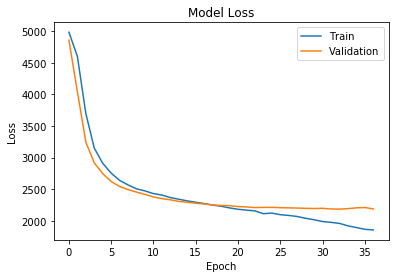

In [51]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(['Train', 'Validation'])

In [52]:
#model the test set
y_pred_train = model.predict([X_name_train, X_train])
y_pred = model.predict([X_name_test, X_test])


train_r2 = round(r2_score(y_train, y_pred_train), 2)
test_r2 = round(r2_score(y_test, y_pred), 2)

print("Training set r2:", train_r2)
print("Testing set r2:", test_r2)

Training set r2: 0.52
Testing set r2: 0.41


In [53]:
y_pred = zero_baseline(y_pred)

test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2 after setting baseline:", test_r2)

mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error after setting baseline:', mse)

me = round(max_error(y_test, y_pred), 2)
print('Max error after setting baseline:', me)

mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error after setting baseline:', mae)

Testing set r2 after setting baseline: 0.41
Mean square error after setting baseline: 2207.13
Max error after setting baseline: 708.25
Mean absolute error after setting baseline: 25.12
